In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Download a compressed archive containing the cat and dog images.
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# Extracted the archive
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Defined paths
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Set hyperparameters:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Create a TensorFlow image dataset from the train directory
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
# Create image datasets from directories containing images and labels
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [4]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

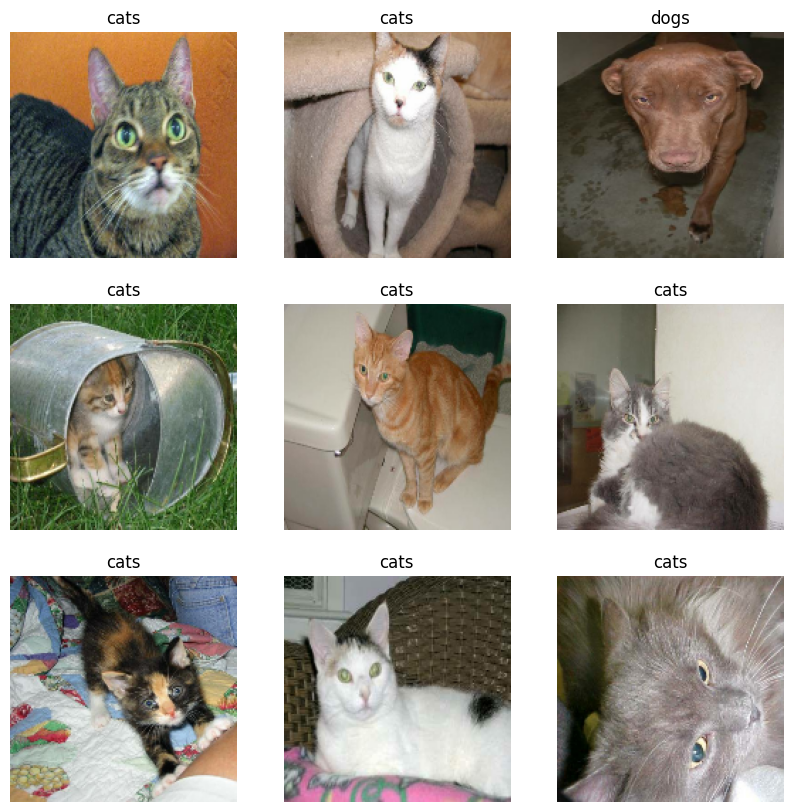

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Counts the total number of batches in the validation_dataset. 
val_batches = tf.data.experimental.cardinality(validation_dataset)

#  takes the first val_batches // 5 batches from the
#  validation_dataset to create the test_dataset
test_dataset = validation_dataset.take(val_batches // 5)

# Skips the first val_batches // 5 batches from
# The original validation_dataset
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'), # Randomly flips images horizontally with a 50% probability.
  tf.keras.layers.RandomRotation(0.2), # randomly rotates images by up to 0.2 radians 
])

In [10]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

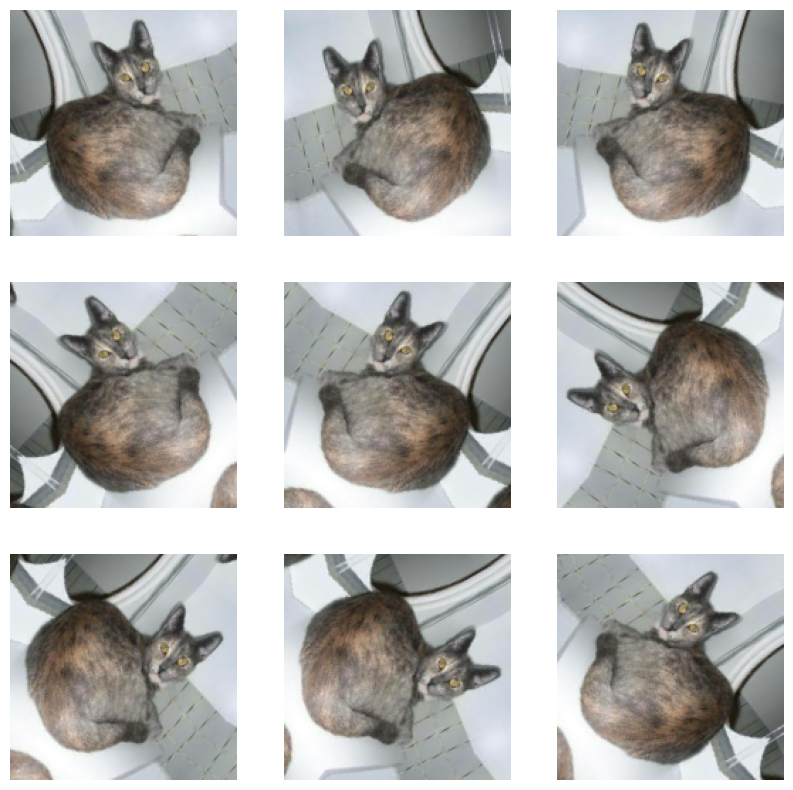

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) #  add batch dimension to the image, making it compatible with the data_augmentation pipeline
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
# preparing images for use with the MobileNetV2 pre-trained model. 
# Resize img - Normilize pixel - Expands to batch dimensions 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # [-2,2] --> [-1,1]

In [14]:
# combines the image size you defined earlier (160, 160) with an additional dimension for 
# color channels (3 for RGB images). This results in (160, 160, 3)
IMG_SHAPE = IMG_SIZE + (3,) 
IMG_SHAPE

(160, 160, 3)

In [15]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, # expected input image shape
                                               include_top=False, # excludes the final classification layers of the pre-trained model, as you want to add your own for cat/dog classification.
                                               weights='imagenet') # loads the pre-trained weights trained on the ImageNet dataset

In [16]:
# retrieves a batch of images and their corresponding labels 
# from the training dataset. This uses the next function 
# to iterate over the dataset and get the first batch.
image_batch, label_batch = next(iter(train_dataset))
# extracts features from the images using the
# pre-trained layers of MobileNetV2.
feature_batch = base_model(image_batch)
#  This means the model extracts 1280 features for each image,
# arranged in a 5x5 grid for each image in the batch.
print(feature_batch.shape) # (batch_size, height, width, features)

(32, 5, 5, 1280)


In [17]:
# freezes the weights of the pre-trained MobileNetV2
# base model in your image classification task
base_model.trainable = False

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [19]:
# This layer performs global average pooling, which means it calculates 
# the average value for each channel across the entire spatial dimensions
# (height and width) of the input feature maps.
# Think of it as summarizing the information contained in each feature 
# map into a single value.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# the layer reduces the spatial dimensions and keeps the number of channels (features),
# resulting in a vector with 1280 values for each image in the batch.
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
#  fully-connected layer with one output neuron(cat, dog).
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs) # creates a Keras model object with the defined input and output layers.

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [23]:
len(model.trainable_variables)

2

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [27]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)


26/26 [==============================] - 13s 335ms/step - loss: 0.6424 - accuracy: 0.6349


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.64
initial accuracy: 0.63


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 39s 488ms/step - loss: 0.6194 - accuracy: 0.6580 - val_loss: 0.4556 - val_accuracy: 0.8181
Epoch 2/10
63/63 [==============================] - 30s 476ms/step - loss: 0.4840 - accuracy: 0.7745 - val_loss: 0.3325 - val_accuracy: 0.9059
Epoch 3/10
63/63 [==============================] - 31s 489ms/step - loss: 0.3822 - accuracy: 0.8385 - val_loss: 0.2643 - val_accuracy: 0.9369
Epoch 4/10
63/63 [==============================] - 33s 522ms/step - loss: 0.3368 - accuracy: 0.8645 - val_loss: 0.2200 - val_accuracy: 0.9455
Epoch 5/10
63/63 [==============================] - 35s 556ms/step - loss: 0.2900 - accuracy: 0.8935 - val_loss: 0.1865 - val_accuracy: 0.9554
Epoch 6/10
63/63 [==============================] - 30s 481ms/step - loss: 0.2598 - accuracy: 0.9040 - val_loss: 0.1635 - val_accuracy: 0.9579
Epoch 7/10
63/63 [==============================] - 27s 433ms/step - loss: 0.2443 - accuracy: 0.9100 - val_loss: 0.1528 - val_accuracy: 0.9641

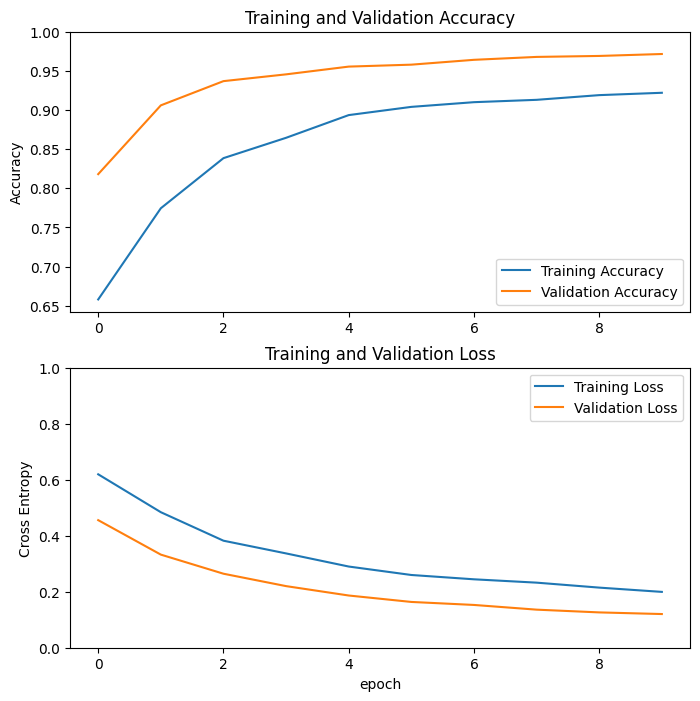

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

FINE TUNNING

In [31]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [34]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")